This notebook contains examples of two different python libraries running anomaly detection on univariate time series data.

# Library: ADTK 
Used for Unsupervised Anomaly Detection on time series data

Refer to: https://arundo-adtk.readthedocs-hosted.com/en/stable/userguide.html

Things to note: 
- Index must be a DatetimeIndex object
- Requires user to know what type of anomalies they want to detect
- Has a cool plotting function for Time series data

In [34]:
import pandas as pd
import datetime as dt
import csv
import urllib
from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import PersistAD
from adtk.detector import SeasonalAD
from adtk.detector import AutoregressionAD

In [16]:
#Using minimum daily temperatures over 10 years (1981-1990) in the city Melbourne, Australia.
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
data = pd.read_csv(url)


#Formatting our Df to have DateTimeIndex objects on index column
def create_DTI_objs(date_str):
    date = date_str.split("-")
    date_obj = dt.datetime(int(date[0]), int(date[1]), int(date[2]))
    return(date_obj)
    
data['Date'] = data['Date'].map(lambda x: dt.datetime(int(x.split("-")[0]), int(x.split("-")[1]), int(x.split("-")[2])))
        
data.set_index('Date', inplace = True)
print(data.head)


<bound method NDFrame.head of             Temp
Date            
1981-01-01  20.7
1981-01-02  17.9
1981-01-03  18.8
1981-01-04  14.6
1981-01-05  15.8
...          ...
1990-12-27  14.0
1990-12-28  13.6
1990-12-29  13.5
1990-12-30  15.7
1990-12-31  13.0

[3650 rows x 1 columns]>


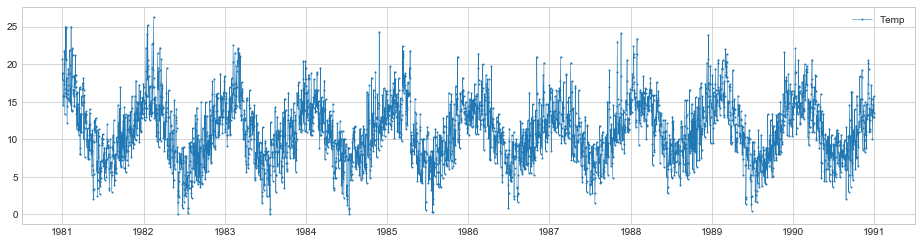

In [17]:
#Call validate_series method to make sure data is in the correct format
data = validate_series(data)
plot(data)

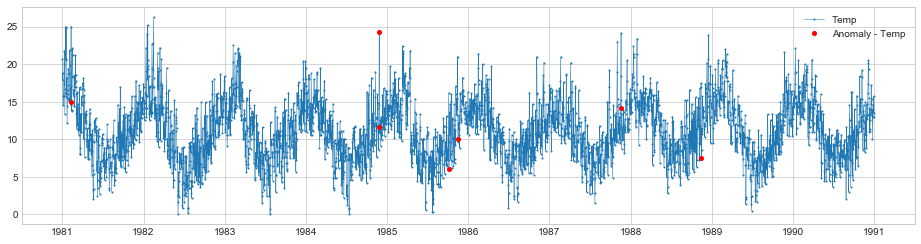

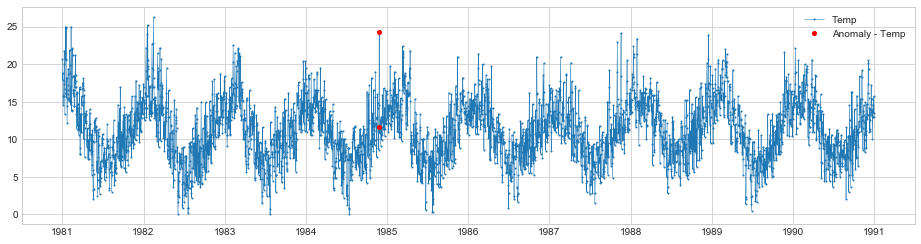

In [37]:
#Detect violation of patterns

persist_ad = PersistAD()
auto_regression_ad = AutoregressionAD()

spike_anomalies = persist_ad.fit_detect(data)
auto_regression = auto_regression_ad.fit_detect(data)

#Plot detected anomalies
plot(data, anomaly = spike_anomalies, anomaly_color="red", anomaly_tag="marker")
plot(data, anomaly = auto_regression, anomaly_color="red",anomaly_tag="marker")

# Facebook Prophet

In [5]:
from fbprophet import Prophet
import pandas as pd
import datetime as dt
from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()
import altair as alt
alt.renderers.enable('notebook')
%matplotlib inline

In [6]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
data = pd.read_csv(url)

In [7]:
model = Prophet()

#To use prophet, columns must be named ds and y
data = data.rename(columns = {'Date': 'ds', "Temp" : "y"})

print(data.columns)


         Date  Temp
0  1981-01-01  20.7
1  1981-01-02  17.9
2  1981-01-03  18.8
3  1981-01-04  14.6
4  1981-01-05  15.8
Index(['ds', 'y'], dtype='object')


In [8]:
#Fits a model to the provided data
def fit_predict_model(dataframe, interval_width = 0.99, changepoint_range = 0.8):
    m = Prophet()
    m = m.fit(dataframe)
    forecast = m.predict(dataframe)
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    return forecast, m

def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    
    #Checks for places where forcasted data is not in the bounds
    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted


In [9]:
pred, m = fit_predict_model(data)
pred = detect_anomalies(pred)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


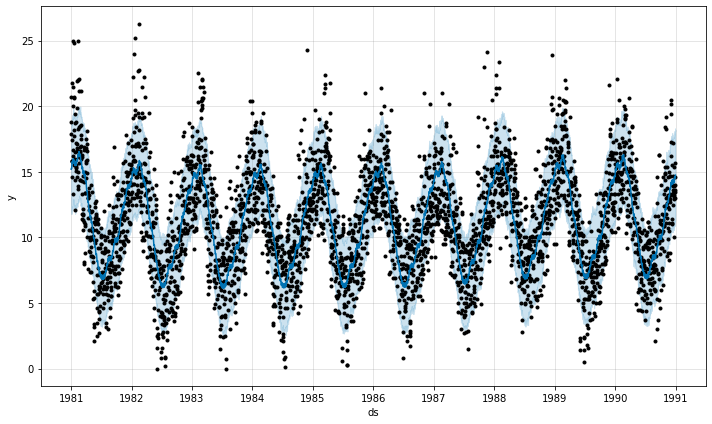

In [10]:
fig = m.plot(pred)

In [13]:
#Just used for generating a prettier plot
def plot_anomalies(forecasted):
    interval = alt.Chart(forecasted).mark_area(interpolate="basis", color = '#7FC97F').encode(
    x=alt.X('ds:T',  title ='date'),
    y='yhat_upper',
    y2='yhat_lower',
    tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive().properties(
        title='Anomaly Detection'
    )

    fact = alt.Chart(forecasted[forecasted.anomaly==0]).mark_circle(size=15, opacity=0.7, color = 'Black').encode(
        x='ds:T',
        y=alt.Y('fact', title='temp'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive()

    anomalies = alt.Chart(forecasted[forecasted.anomaly!=0]).mark_circle(size=30, color = 'Red').encode(
        x='ds:T',
        y=alt.Y('fact', title='temp'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper'],
        size = alt.Size( 'importance', legend=None)
    ).interactive()

    return alt.layer(interval, fact, anomalies)\
              .properties(width=870, height=450)\
              .configure_title(fontSize=20)

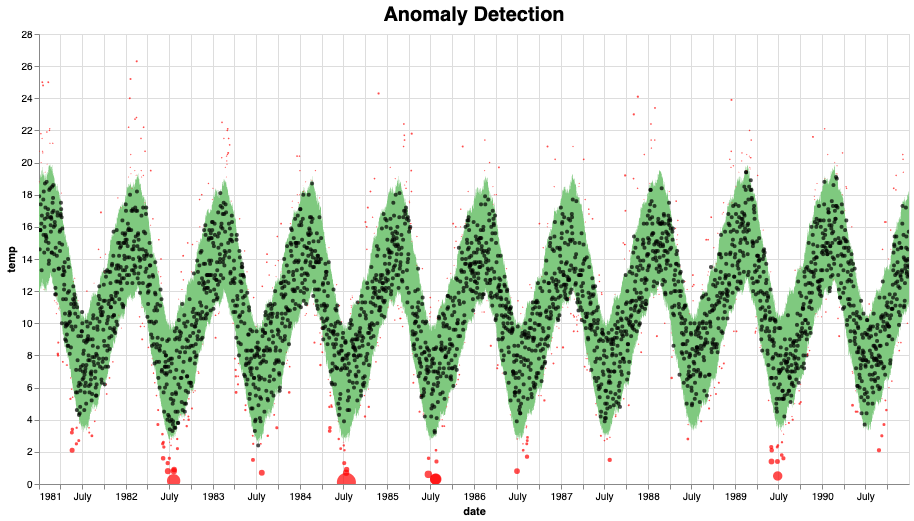

In [14]:
plot_anomalies(pred)